In [1]:
from IPython.display import Image

# Valores missing, outlier y correlaciones

En este notebook se realiza el estudio y preprocesamiento de las variables numéricas y categoricas. Se realizarán los siguientes pasos:

    1. Cambio de tipos de variables
    2. Separación en train y test
    3. Análisis de cada variable con gráficos descriptivos
    4. Para variables numericas: correlaciones de pearson, estudio de  outliers y estudio de valores missing
    5. Para variables categoricas: relleno de valores missing, estudio de correlaciones con vCramer

Para los valores outlier por columnas, se tendrá en cuenta los gráficos:

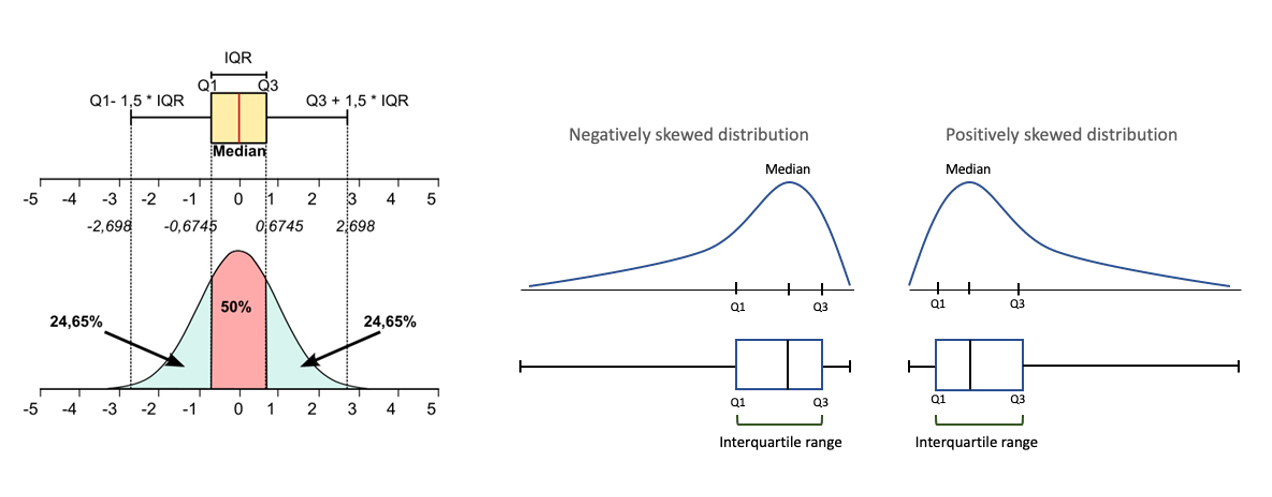

Dentro del tratamiento de los valores missing, se elegirá alguno de los siguientes métodos:

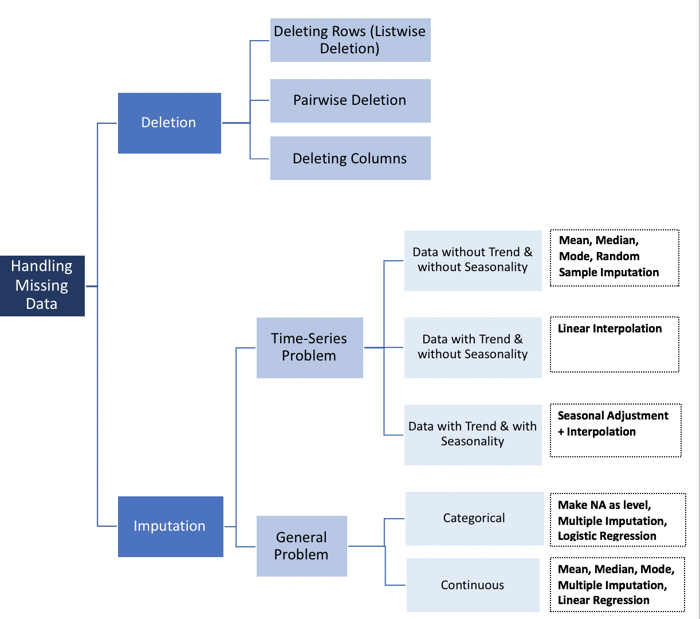

## Importo librerías

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

## Funciones
#### Buenas prácticas

Voy guardando las funciones que están automatizadas y pienso que me van a servir en otros proyectos en un funciones_auxiliares.py y lo importo:

In [3]:
#import funciones_auxiliares as f_aux
# Si importas las funciones del .py de esta forma, para llamar a una función habría que hacer: f_aux.plot_feature(...)
# y eliminar la siguiente celda de funciones, ya que ya las estaríamos importando desde funciones_auxiliares.py

In [4]:
def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the fraud.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df, x=col_name, color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    

def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
        -Descripción: Función que recibe un dataset y devuelve una lista con los nombres de las 
        variables categóricas
        -Inputs: 
            -- dataset: Pandas dataframe que contiene los datos
        -Return:
            -- lista_variables_categoricas: lista con los nombres de las variables categóricas del
            dataset de entrada con menos de 100 valores diferentes
            -- 1: la ejecución es incorrecta
    '''
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype!=float) & (dataset[i].dtype!=int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other


def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_fraud, list_var_continuous, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_fraud[i].mean()
        series_std = pd_fraud[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_fraud[i].size
        
        perc_goods = pd_fraud[i][(pd_fraud[i] >= left) & (pd_fraud[i] <= right)].size/size_s
        perc_excess = pd_fraud[i][(pd_fraud[i] < left) | (pd_fraud[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_fraud[target][(pd_fraud[i] < left) | (pd_fraud[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('fraud_bool',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_fraud[i][(pd_fraud[i] < left) | (pd_fraud[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final


def get_percent_null_values_target(pd_fraud, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_fraud[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_fraud[target][pd_fraud[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('fraud_bool',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_fraud[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_fraud[i].isnull().sum()/pd_fraud.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final



def cramers_v(confusion_matrix):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

## Lectura de datos del preprocesado inicial
Lectura de los datos y cambio de tipos de variables

In [5]:
pd_fraud = pd.read_csv("data/Base.csv")
pd_fraud.shape

(1000000, 32)

In [6]:
pd_fraud.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

Observamos que dentro de nuestro dataset hay tanto variables categóricas (tal y como se ha visto en el notebook 01), variables float (continuas) y variables int (números enteros)

In [7]:
lista_variables_categoricas = ["payment_type","employment_status","housing_status","email_is_free","phone_home_valid",
                                "phone_mobile_valid","has_other_cards","foreign_request","source","device_os","keep_alive_session", "fraud_bool"]

In [8]:
for columna in lista_variables_categoricas:
    pd_fraud[columna] = pd_fraud[columna].astype('category')
    
lista_variables_categoricas

['payment_type',
 'employment_status',
 'housing_status',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'foreign_request',
 'source',
 'device_os',
 'keep_alive_session',
 'fraud_bool']

A continuación transformamos 5 de las variables a formato decimal.

In [9]:
pd_fraud['prev_address_months_count']= pd_fraud['prev_address_months_count'].astype(float)
pd_fraud['current_address_months_count']= pd_fraud['current_address_months_count'].astype(float)
pd_fraud['zip_count_4w']= pd_fraud['zip_count_4w'].astype(float)
pd_fraud['bank_branch_count_8w']= pd_fraud['bank_branch_count_8w'].astype(float)
pd_fraud['credit_risk_score']= pd_fraud['credit_risk_score'].astype(float)

## Separación en train y test estratificado

In [10]:
import plotly.express as px

In [11]:
pd_plot_fraud_bool = pd_fraud['fraud_bool']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

pd_plot_fraud_bool_conteo = pd_fraud['fraud_bool'].value_counts().reset_index()
pd_plot_fraud_bool_pc = pd.merge(pd_plot_fraud_bool, 
                                  pd_plot_fraud_bool_conteo, on=['fraud_bool'], how='inner')

fig = px.histogram(pd_plot_fraud_bool_pc, x='fraud_bool', y='percent', labels={'fraud_bool': 'Fraud Status', 'percent': 'Percentage'})
fig.show()

De nuevo, obtenemos el histograma del notebook 01

In [12]:
from sklearn.model_selection import train_test_split
X_pd_fraud, X_pd_fraud_test, y_pd_fraud, y_pd_fraud_test = train_test_split(pd_fraud.drop('fraud_bool',axis=1), 
                                                                     pd_fraud['fraud_bool'], 
                                                                     stratify=pd_fraud['fraud_bool'], 
                                                                     test_size=0.2)
pd_fraud_train = pd.concat([X_pd_fraud, y_pd_fraud],axis=1)
pd_fraud_test = pd.concat([X_pd_fraud_test, y_pd_fraud_test],axis=1)

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [13]:
print('== Train\n', pd_fraud_train['fraud_bool'].value_counts(normalize=True))
print('== Test\n', pd_fraud_test['fraud_bool'].value_counts(normalize=True))

== Train
 fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64
== Test
 fraud_bool
0    0.98897
1    0.01103
Name: proportion, dtype: float64


Se observa la división entre train y test para la variable objetivo de nuestro dataset. 
Vemos que los datos de train y test son los mismos porcentajes pero esto no quiere decir que sea el mismo número de registros (normalize=True). Esto se hace por si la variable objetivo está desbalanceada se haga el corte entre el train y el test equilibrado.

## Visualización descriptiva de los datos

Distribución de las variables

In [14]:
pd_fraud_train.columns

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'fraud_bool'],
      dtype='object')

Creamos dos variables que recogen por un lado, las variables categóricas del dataframe (lista_variables_categoricas), y por otro lado, las variables numéricas tanto enteras como float como binarias (lista_variables_numericas)

In [15]:
lista_variables_categoricas = ["payment_type","employment_status","housing_status","email_is_free","phone_home_valid",
                                "phone_mobile_valid","has_other_cards","foreign_request","source","device_os","keep_alive_session", "fraud_bool"]

lista_variables_numericas = ["income", "name_email_similarity", "prev_address_months_count", "current_address_months_count", "customer_age", "days_since_request",
                            "intended_balcon_amount", "zip_count_4w", "velocity_6h", "velocity_24h", "velocity_4w", "bank_branch_count_8w", "date_of_birth_distinct_emails_4w",
                            "credit_risk_score", "bank_months_count", "proposed_credit_limit", "session_length_in_minutes", "device_distinct_emails_8w", "device_fraud_count",
                            "month"]
target = 'fraud_bool'
pd_fraud_train[target] = pd_fraud_train[target].astype(str)

La siguiente celda del código se utiliza para realizar visualizaciones de las características en el DataFrame pd_fraud_train. Este enfoque facilita obtener una comprensión rápida de cómo diferentes características se relacionan con la variable objetivo.

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: Fu

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\sarim\AppData\Local\Temp\ipykernel_42004\2343862388.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and 

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: Future

C:\Users\sarim\AppData\Local\Temp\ipykernel_42004\2343862388.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and 

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\sarim\AppData\Local\Temp\ipykernel_42004\2343862388.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and 

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: Future

CPU times: total: 21.7 s
Wall time: 2min 46s


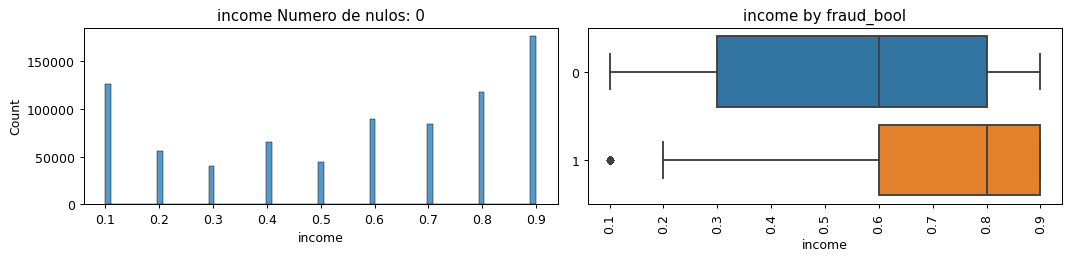

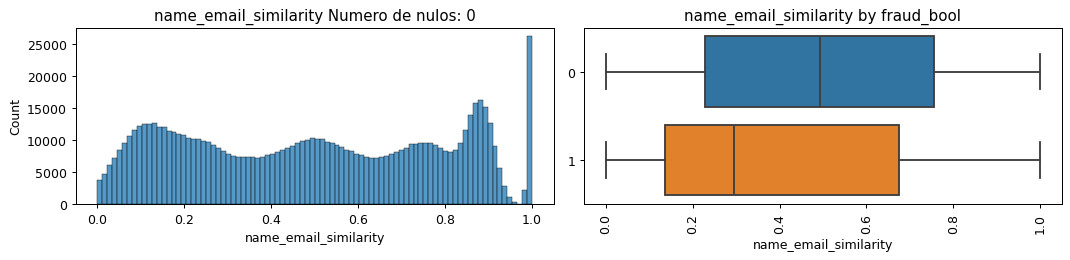

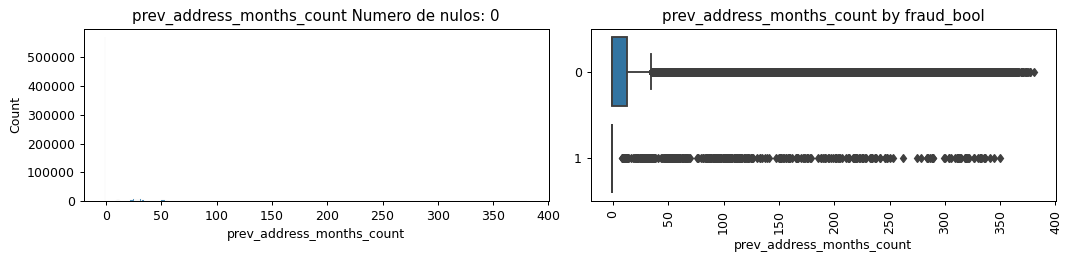

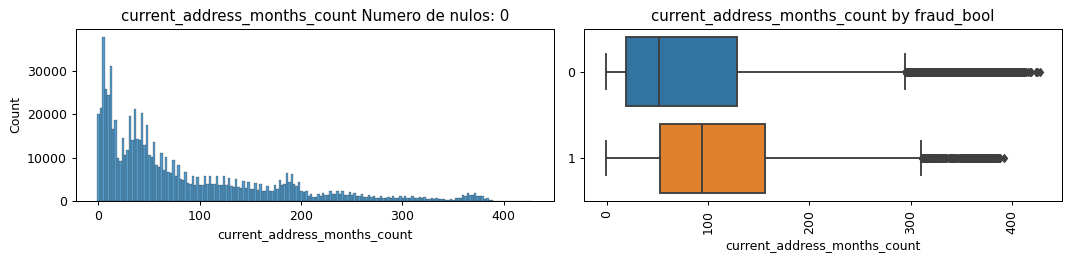

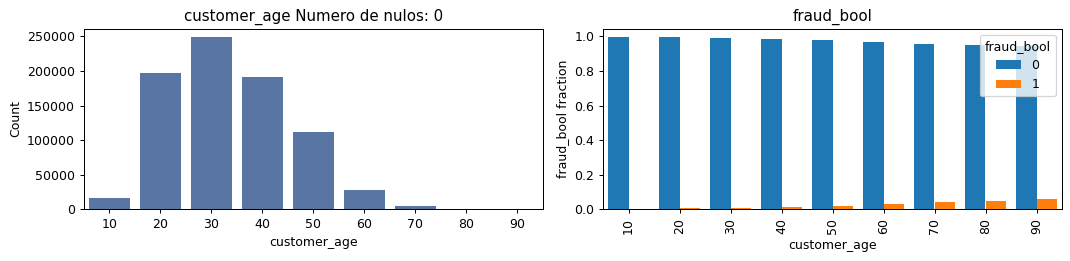

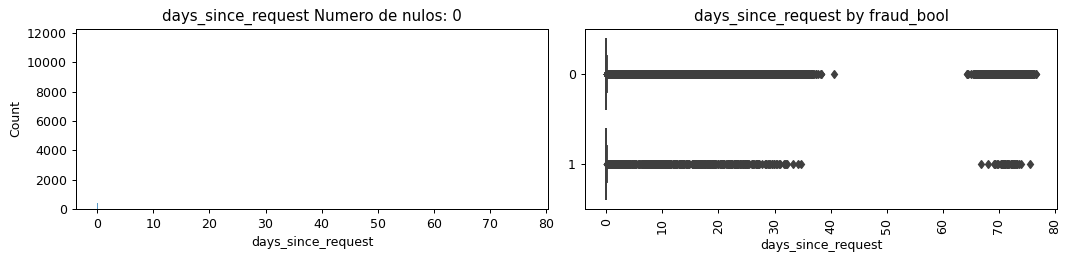

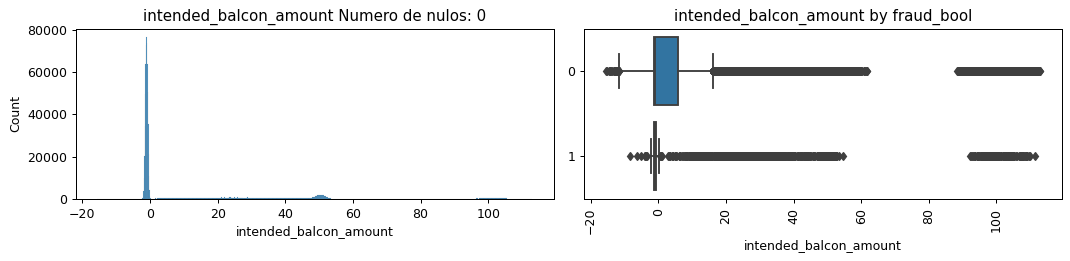

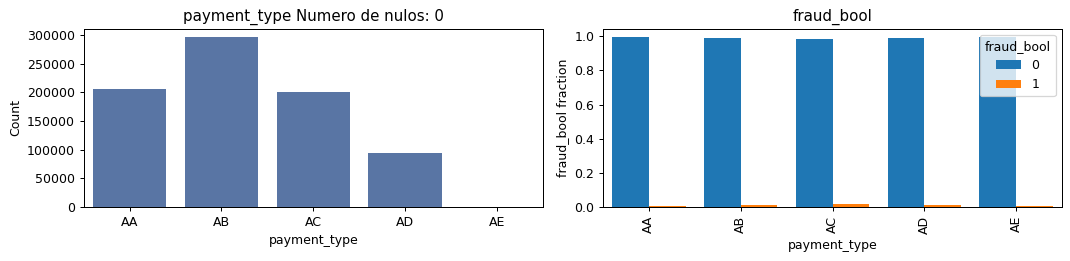

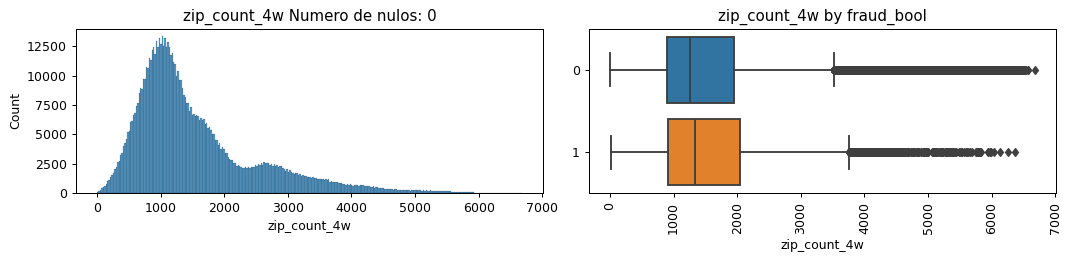

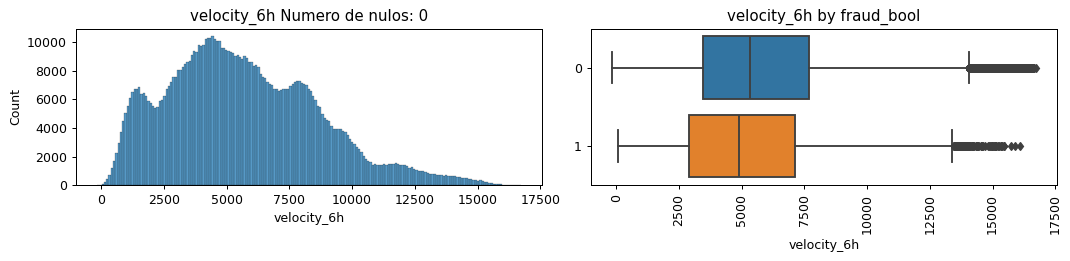

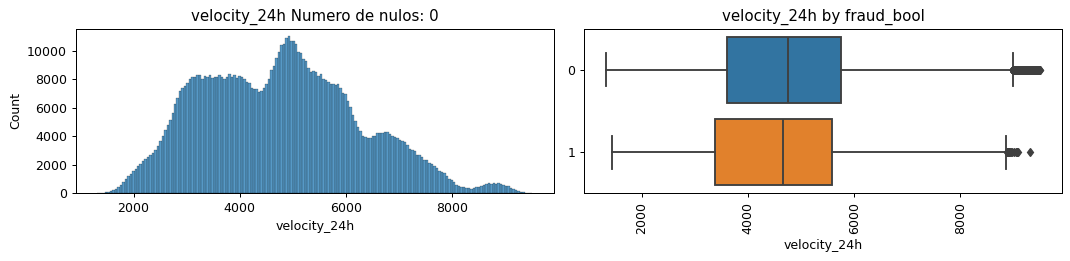

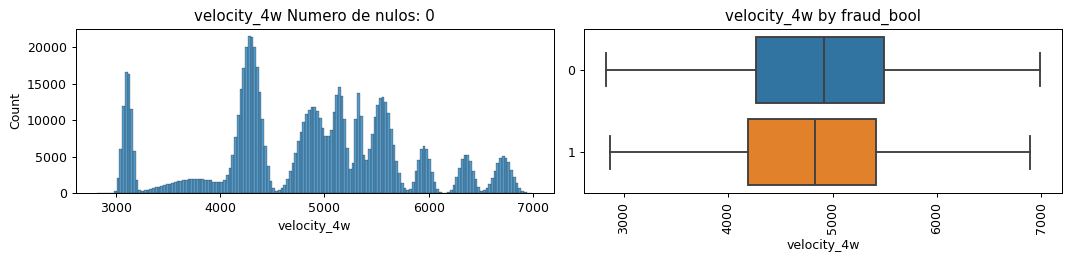

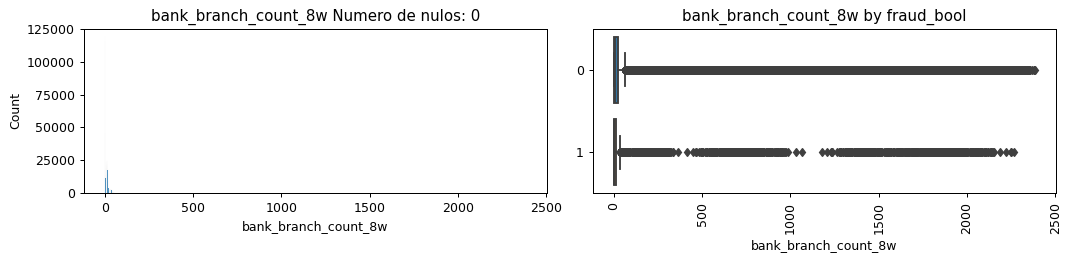

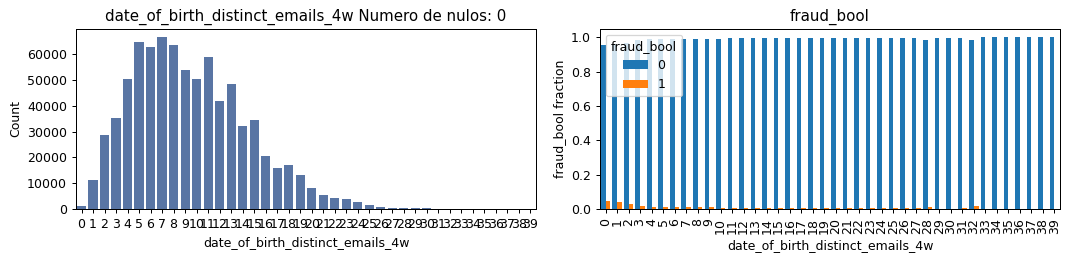

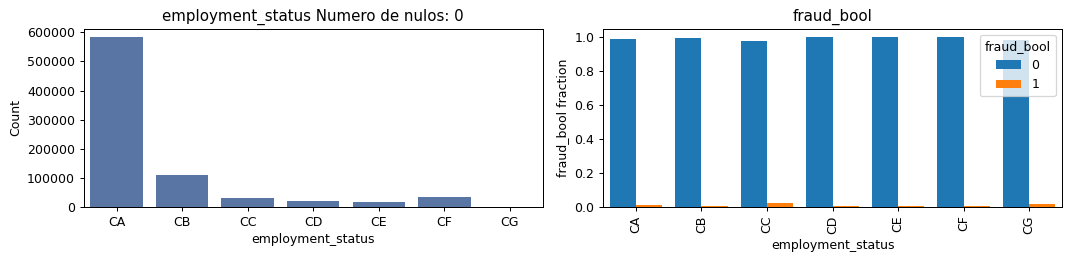

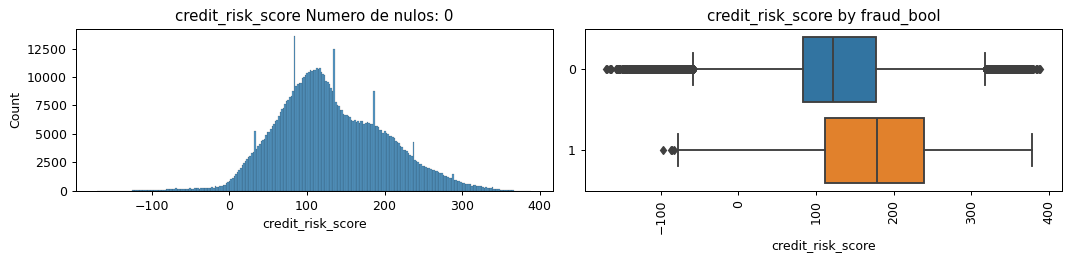

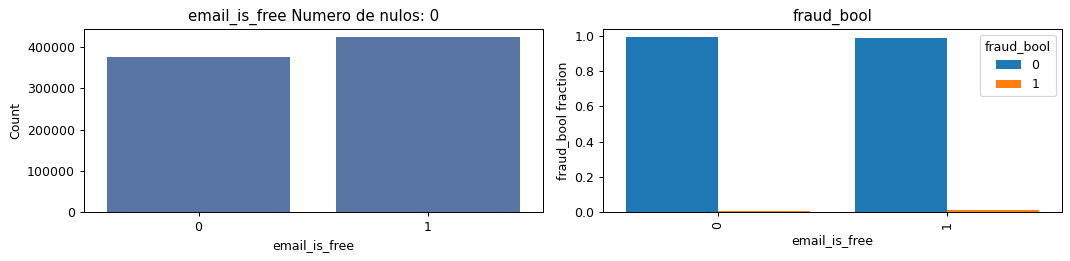

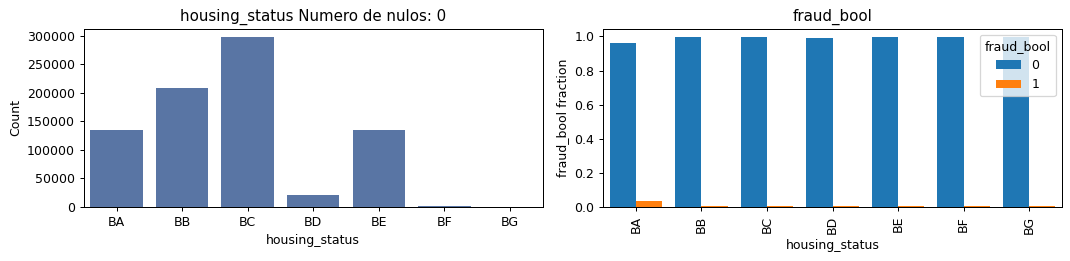

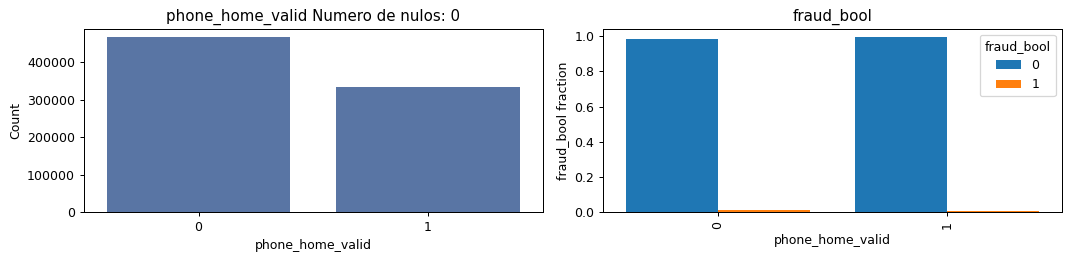

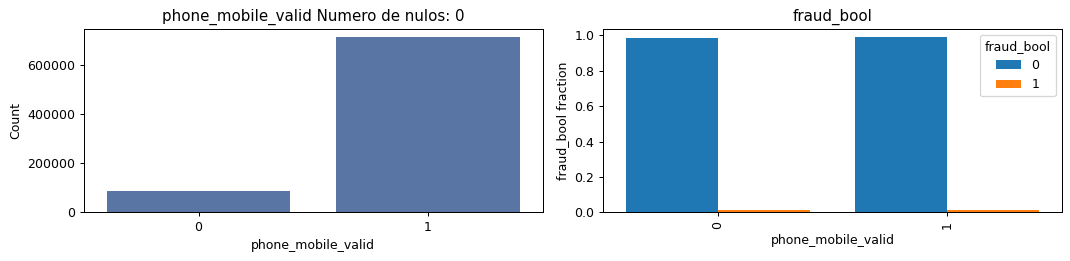

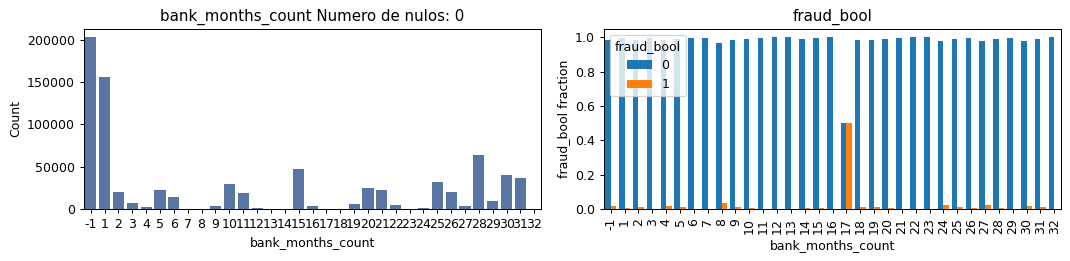

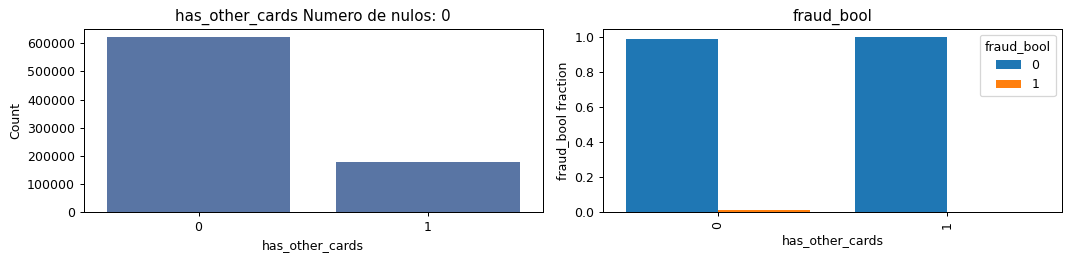

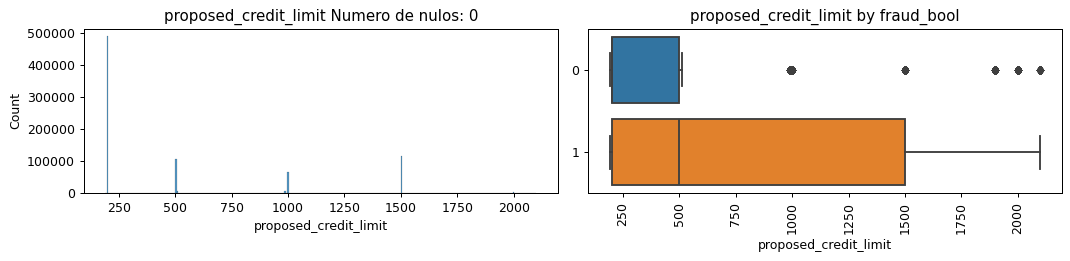

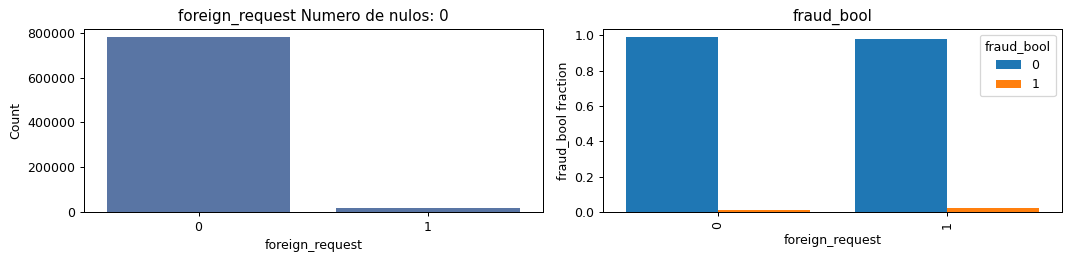

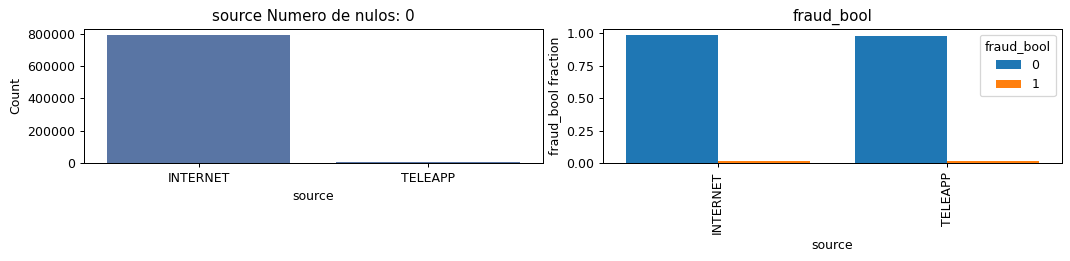

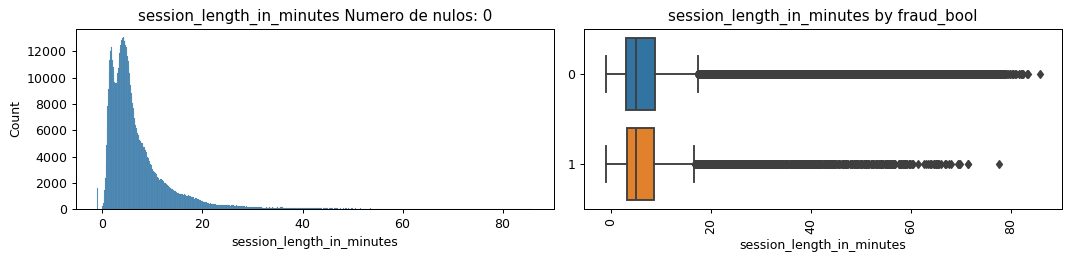

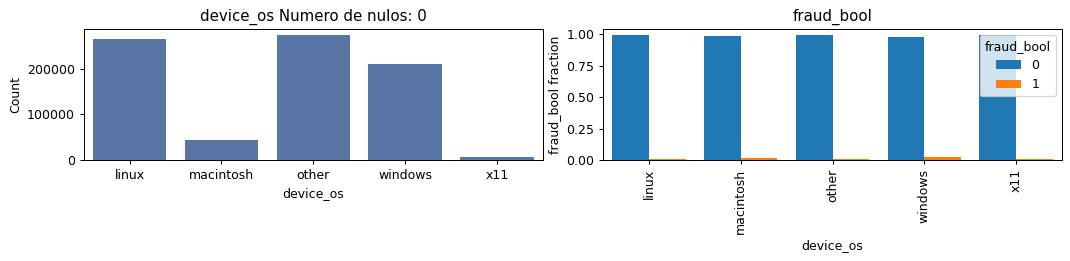

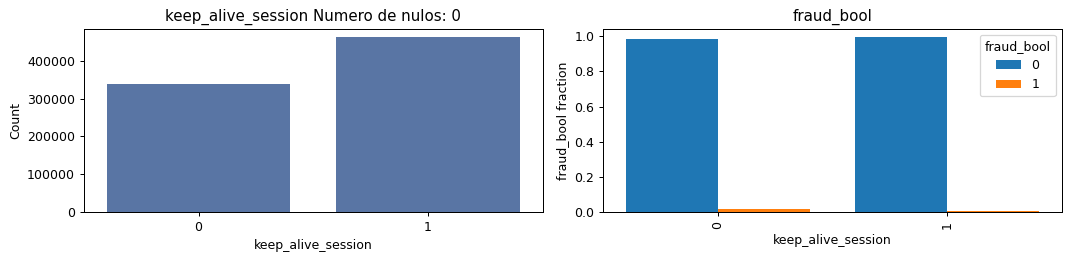

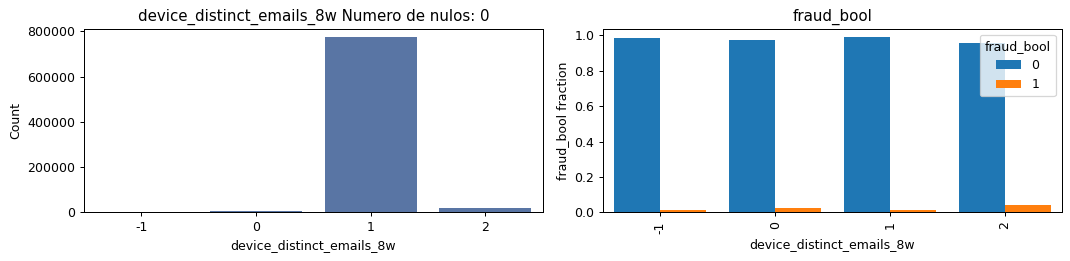

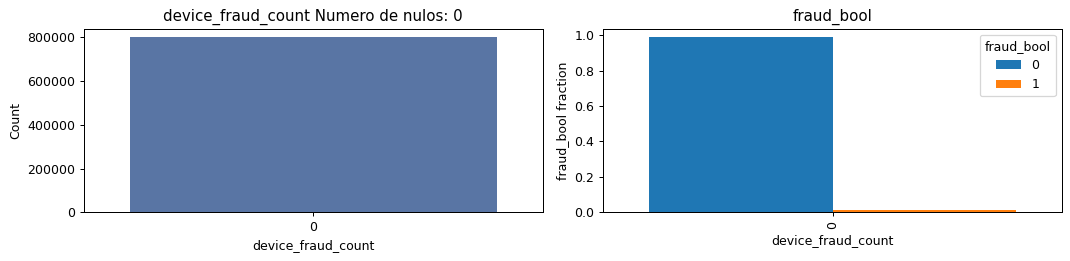

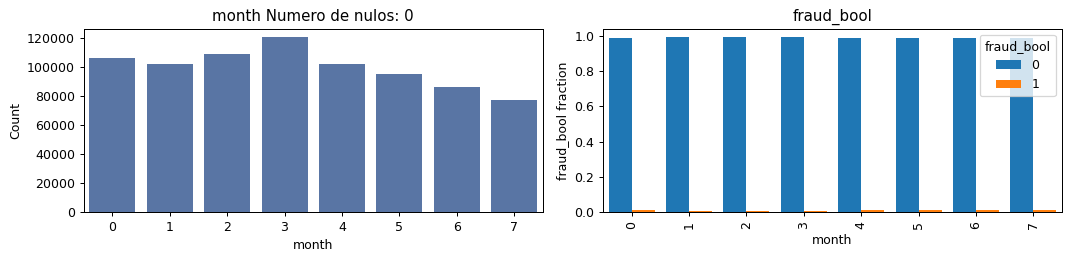

In [16]:
%%time
for i in list(pd_fraud_train.columns):
    if (pd_fraud_train[i].dtype==float) & (i!='fraud_bool'):
        plot_feature(pd_fraud_train, col_name=i, isContinuous=True, target='fraud_bool')
    elif  i!='fraud_bool':
        plot_feature(pd_fraud_train, col_name=i, isContinuous=False, target='fraud_bool')

#### Comentarios de los gráficos

Comentarios de los gráficos más relevantes:

 - En el primer gráfico boxplot podemos ver que hay una diferencia clara entre las medias de 'income' cuando medimos los datos fraudulentos contra los no fraudulentos, siendo mucho mayor en los casos en los que se comete fraude. Esto puede llevar a pensar que las cuentas con más income tienden a ser fraudulentas. Un estudio más profundo sobre esta relación podría ser interesante.
 - Como podemos ver en el gráfico de barras de 'name_email_similarity', la mayoría de la gente pone su nombre en la dirección del email.
 - En el boxplot no hay diferencias significativas por lo que probablemente no tenga relación el nombre del email con la posibilidad de que las aplicaciones sean fraudulentas o no.
 - Observamos que los dos bigotes de la caja boxplot de la variable 'prev_address_months_count' indica que al menos el 50% de las aplicaciones fraudulentas presentan esta variable como valor faltante. Esta variable podría ser relevante para detectar los fraudes.
 - El gráfico de barras de la variable 'customer_age' muestra un dato muy relevante: que se utilizan cuentas de personas más mayores para generar aplicaciones fraudulentas. 
 - En el histograma de 'intended_balcon_amount' podemos ver que casi nunca se introduce dinero al iniciar una aplicación. Eso sumado a que los gráficos boxplots son muy parecidos, indica que esta variable no sería muy útil para el estudio.
 - En el gráfico de barras de 'date_of_birth_distinct_emails_4w' observamos que hay 4 semanas dignas de mención (0,1,2,36). Un estudio más a fondo podría ser interesante.
 - A pesar de que en el histograma de 'employment_status' se observen que el que más se repiten son los CA y que los grupos CC y en especial CG apenas carecen de aplicaciones, en el gráfico de barras observamos que el employment_status CC y CG tiende a ser utilizado para crear aplicaciones fraudulentas.
 - A pesar de que en el histograma de 'housing_status' se observen que el que más se repiten son los BC, en el gráfico de barras observamos que el housing_status BA tiende a ser más utilizado para crear aplicaciones fraudulentas.
 - En el gráfico de barras de 'bank_months_count' observamos que los usuarios crean más cuentas fraudulentas cuando la cuenta bancaria de un cliente tiene 17 meses.
 - En el boxplot de 'proposed_credit_limit' se muestra que las aplicaciones fraudulentas se tienden a crear con un límite de cuenta mayor, lo que tiene lógica puesto que se quiere obtener confianza.
 - En el histograma de 'foreign_request' podemos ver que no hay muchas cuentas con esta variable igual a 1, y en el gráfico de barras entonces podemos observar una ligera diferencia. Cuentas con este valor se pueden llegar a utilizar más para crear aplicaciones fraudulentas.
 - Gráficos keep_alive_session: Las cuentas con aplicaciones fraudulentas tienden a dejarse la cuenta abierta lo cual tiene sentido porque así no se requiere introducir contraseñas.
 - Las aplicaciones fraudulentas es probable que se creen desde el mismo dispositivo, y esto puede explicar que en el gráfico de barras de 'device_distinct_emails_8w' el valor que más se repita sea el 2.
 
 - No se aprecian diferencias significativas en los gráficos boxplot ni información relevante en los histogramas: 'payment_type', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'source', 'device_os', 'current_adress_months_count', 'days_since_request', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'credit_risk_score', 'session_length_in_minutes', 'device_fraud_count'y 'month'.

## - Tratamiento de las variables numericas

A continuación, se tratan los valores missing, las correlaciones de las variables numericas y los outlier

In [17]:
lista_variables_numericas

['income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'bank_months_count',
 'proposed_credit_limit',
 'session_length_in_minutes',
 'device_distinct_emails_8w',
 'device_fraud_count',
 'month']

### Tratamiento de outliers

Los valores outlier se pueden sustituir por la media, mediana, valores extremos (media+3std o media-3std). Tras el siguiente análisis, hemos decidido como primera iteración dejarlos sin sustituir. Una vez lleguemos al modelo puedo realizar iteraciones utilizando diferentes métodos para comprobar si mejora el modelo.

In [18]:
pd_fraud_train

income  name_email_similarity  prev_address_months_count  \
844931     0.2               0.141930                       -1.0   
754426     0.3               0.346878                       31.0   
715567     0.1               0.843095                       -1.0   
850530     0.1               0.152189                       25.0   
916672     0.4               0.998324                       -1.0   
...        ...                    ...                        ...   
792889     0.1               0.730265                       54.0   
769034     0.2               0.429537                       27.0   
405102     0.1               0.244073                       -1.0   
529726     0.8               0.510365                       -1.0   
816585     0.9               0.232059                       -1.0   

        current_address_months_count  customer_age  days_since_request  \
844931                          40.0            50            0.024422   
754426                          11.0            30            0.011844   
715567                         206.0            50            0.774946   
850530                           1.0            20           68.075714   
916672                          35.0            50            0.004613   
...                              ...           ...                 ...   
792889                          16.0            20            0.018541   
769034                          13.0            60            1.175316   
405102                         283.0            40            3.850229   
529726                         149.0            20            0.003480   
816585                          65.0            30            0.002175   

        intended_balcon_amount payment_type  zip_count_4w  velocity_6h  \
844931               -1.412505           AB        2504.0  8838.670678   
754426               52.591384           AA         738.0  2572.523408   
715567               49.445788           AA        4790.0  7852.149227   
850530               -0.598303           AC         717.0  4710.489115   
916672               -1.547372           AB        1077.0  6930.311123   
...                        ...          ...           ...          ...   
792889               -1.055121           AC         566.0  6503.467682   
769034               -1.259155           AC         849.0  2704.249089   
405102               -0.497876           AC        1645.0  3688.615016   
529726               -0.489399           AD        1957.0  1791.236767   
816585               -0.675794           AB         849.0   809.496910   

        velocity_24h  velocity_4w  bank_branch_count_8w  \
844931   5048.335872  4263.532921                   4.0   
754426   7816.818383  4218.950926                  11.0   
715567   4281.170377  6771.263190                1354.0   
850530   5830.846361  4379.146843                   1.0   
916672   5181.562318  4176.094149                  22.0   
...              ...          ...                   ...   
792889   3032.637862  4257.734586                1904.0   
769034   4915.168946  4313.915365                   0.0   
405102   4846.934917  5431.954408                   1.0   
529726   2841.291183  4275.514597                  15.0   
816585   2628.615638  4179.454984                  16.0   

        date_of_birth_distinct_emails_4w employment_status  credit_risk_score  \
844931                                 7                CA              125.0   
754426                                 9                CA               82.0   
715567                                 4                CB               67.0   
850530                                11                CA               88.0   
916672                                 2                CB               90.0   
...                                  ...               ...                ...   
792889                                 9                CA              177.0   
769034                                 6                

In [19]:
get_deviation_of_mean_perc(pd_fraud_train, lista_variables_numericas, target='fraud_bool', multiplier=3)

0         1                          variable  sum_outlier_values  \
0   0.993412  0.006588         prev_address_months_count               20189   
1   0.983869  0.016131      current_address_months_count               17172   
2   0.956831  0.043169                      customer_age                6324   
3   0.987552  0.012448                days_since_request               14300   
4   0.990352  0.009648            intended_balcon_amount               15133   
5   0.990161  0.009839                      zip_count_4w               13010   
6   0.992777  0.007223                       velocity_6h                3461   
7   0.997701  0.002299                      velocity_24h                 435   
8   0.989898  0.010102              bank_branch_count_8w               32767   
9   0.993182  0.006818  date_of_birth_distinct_emails_4w                4987   
10  0.965901  0.034099                 credit_risk_score                2962   
11  0.869654  0.130346             proposed_credit_limit                4910   
12  0.980115  0.019885         session_length_in_minutes               18858   
13  0.963353  0.036647         device_distinct_emails_8w               25514   

    porcentaje_sum_null_values  
0                     0.025236  
1                     0.021465  
2                     0.007905  
3                     0.017875  
4                     0.018916  
5                     0.016262  
6                     0.004326  
7                     0.000544  
8                     0.040959  
9                     0.006234  
10                    0.003703  
11                    0.006137  
12                    0.023572  
13                    0.031892

La función anterior calcula la desviación de la media para cada variable numerica con respecto a la variable objetivo (fraud_bool) y, en función del multiplicador, identifica los outliers. Este enfoque es común en la detección de outliers para resaltar observaciones que tienen un gran impacto en el comportamiento de la variable objetivo con las variables numéricas.

Se puede observar que en la variable proposed_credit_limit los outliers tienen un mayor porcentaje (0.13213) de fraud_bool=1 (solicitud fraudulenta).

### Correlaciones

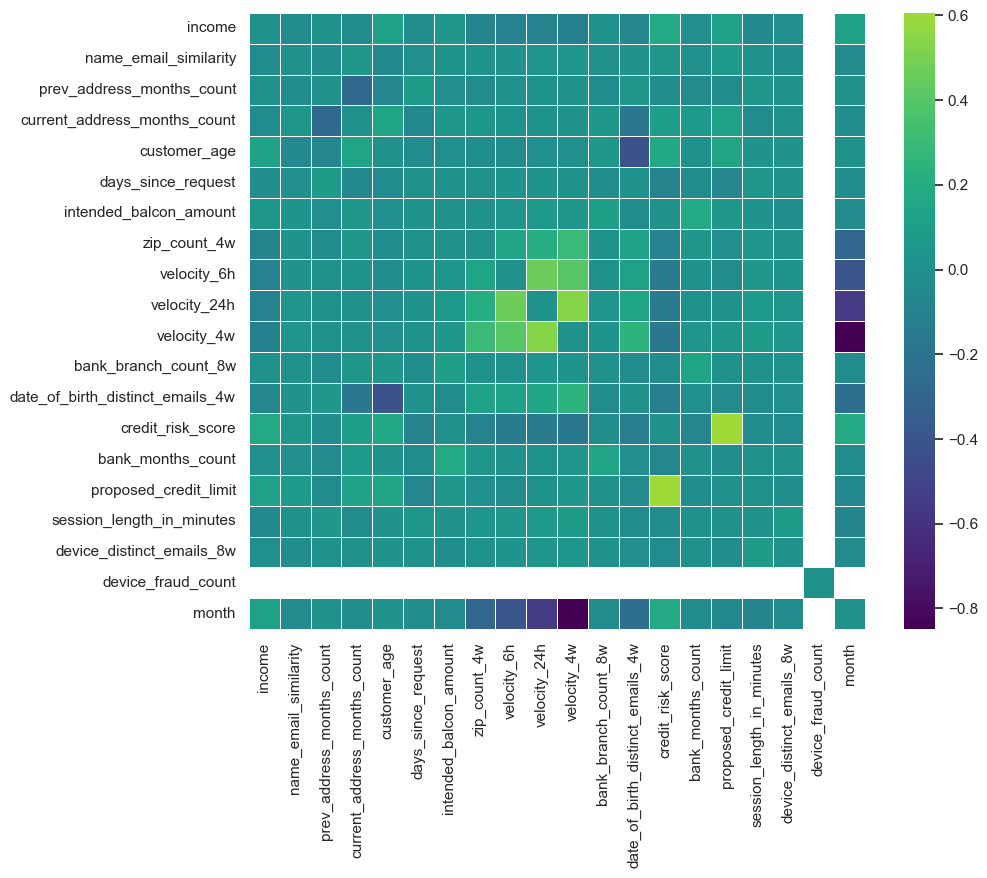

0

In [20]:
get_corr_matrix(dataset = pd_fraud_train[lista_variables_numericas], 
                metodo='pearson', size_figure=[10,8])

 - De la información más llamativa del gráfico superior es que las velocidades "velocity_24h" y "velocity_4w" y las variables 'credit_risk_score' y 'proposed_credit_limit' son las que poseen un mayor grado de correlación positiva entre sí (alrededor de un 60%)
 - Además podemos destacar que, en valor absoluto, las variables más correlacionadas de la matriz superior son 'month' y 'velocity_4w' con un 84,80% de correlación.

In [21]:
corr = pd_fraud_train[lista_variables_numericas].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.5]

level_0            level_1  correlation
372                  month        velocity_4w     0.848313
313  proposed_credit_limit  credit_risk_score     0.605689
371                  month       velocity_24h     0.549924
209            velocity_4w       velocity_24h     0.538996

Comprobamos las variables que tienen una correlación mayor a un 50%.

In [22]:
new_corr

level_0                           level_1  \
372                             month                       velocity_4w   
313             proposed_credit_limit                 credit_risk_score   
371                             month                      velocity_24h   
209                       velocity_4w                      velocity_24h   
188                      velocity_24h                       velocity_6h   
244  date_of_birth_distinct_emails_4w                      customer_age   
370                             month                       velocity_6h   
208                       velocity_4w                       velocity_6h   
207                       velocity_4w                      zip_count_4w   
369                             month                      zip_count_4w   
62       current_address_months_count         prev_address_months_count   
374                             month  date_of_birth_distinct_emails_4w   
250  date_of_birth_distinct_emails_4w                       velocity_4w   
187                      velocity_24h                      zip_count_4w   
286                 bank_months_count            intended_balcon_amount   
375                             month                 credit_risk_score   
243  date_of_birth_distinct_emails_4w      current_address_months_count   
260                 credit_risk_score                            income   
270                 credit_risk_score                       velocity_4w   
264                 credit_risk_score                      customer_age   
249  date_of_birth_distinct_emails_4w                      velocity_24h   
304             proposed_credit_limit                      customer_age   
269                 credit_risk_score                      velocity_24h   
268                 credit_risk_score                       velocity_6h   
83                       customer_age      current_address_months_count   
167                       velocity_6h                      zip_count_4w   
291                 bank_months_count              bank_branch_count_8w   
272                 credit_risk_score  date_of_birth_distinct_emails_4w   
303             proposed_credit_limit      current_address_months_count   
247  date_of_birth_distinct_emails_4w                      zip_count_4w   
80                       customer_age                            income   
248  date_of_birth_distinct_emails_4w                       velocity_6h   
362                             month                            income   
300             proposed_credit_limit                            income   
200                       velocity_4w                            income   
226              bank_branch_count_8w            intended_balcon_amount   
267                 credit_risk_score                      zip_count_4w   
180                      velocity_24h                            income   
160                       velocity_6h                            income   
263                 credit_risk_score      current_address_months_count   
265                 credit_risk_score                days_since_request   
140                      zip_count_4w                            income   
378                             month         session_length_in_minutes   
102                days_since_request         prev_address_months_count   
330         session_length_in_minutes                       velocity_4w   
356         device_distinct_emails_8w         session_length_in_minutes   
301             proposed_credit_limit             name_email_similarity   
283                 bank_months_count      current_address_months_count   
82                       customer_age         prev_address_months_count   
305             proposed_credit_limit                days_since_request   
329         session_length_in_minutes                      velocity_24h   
186                      velocity_24h            intended_balcon_amount   
240  date_of_birth_distinct_emails_4w                  

Decidimos en esta primera iteración, no eliminar correlaciones. Sin embargo, si finalmente aplicamos algún algoritmo que lo requiera, tendremos que eliminar correlaciones.

### Tratamiento de valores nulos

In [23]:
lista_variables_numericas

['income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'bank_months_count',
 'proposed_credit_limit',
 'session_length_in_minutes',
 'device_distinct_emails_8w',
 'device_fraud_count',
 'month']

In [24]:
get_percent_null_values_target(pd_fraud_train, lista_variables_numericas, target='fraud_bool')

No existen variables con valores nulos


Empty DataFrame
Columns: []
Index: []

Como ya hemos adelantado en el primer notebook, los missings en este dataset no están codificados como NAs, si no como -1 o como valores negativos. Por esta razón, el código muestra el mensaje: 'No existen variables con valores nulos' a pesar de que todas las variables que contienen missings formen parte de 'lista_variables_numericas'.

## - Tratamiento de las variables categoricas

In [25]:
lista_variables_categoricas

['payment_type',
 'employment_status',
 'housing_status',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'foreign_request',
 'source',
 'device_os',
 'keep_alive_session',
 'fraud_bool']

Calculamos el coeficiente de Cramer para ver la relación entre una variable categórica y la variable objetivo.
Escogemos dos variables aleatorias.

In [26]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["payment_type"])
print(confusion_matrix)
cramers_v(confusion_matrix.values)

payment_type      AA      AB      AC     AD   AE
fraud_bool                                      
0             205500  293306  198169  93981  221
1               1097    3305    3389   1031    1


0.03929832455278903

Coeficiente de Cramer prácticamente nulo, prácticamente ninguna relación

In [27]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["fraud_bool"])
cramers_v(confusion_matrix.values)

0.9999426978916621

El resultado obtenido en esta línea de código tiene sentido puesto que la relación existente entre una variable consigo misma es de 1

In [28]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["date_of_birth_distinct_emails_4w"])
cramers_v(confusion_matrix.values)

0.06243118840944539

In [29]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["customer_age"])
cramers_v(confusion_matrix.values)

0.06708666095660588

In [30]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["employment_status"])
cramers_v(confusion_matrix.values)

0.03928772388675474

In [31]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["email_is_free"])
cramers_v(confusion_matrix.values)

0.028257098698935404

In [32]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["housing_status"])
cramers_v(confusion_matrix.values)

0.11509684153964615

In [33]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["phone_home_valid"])
cramers_v(confusion_matrix.values)

0.03555196601878687

In [34]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["phone_mobile_valid"])
cramers_v(confusion_matrix.values)

0.01245751012983334

In [35]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["bank_months_count"])
cramers_v(confusion_matrix.values)

0.05026673622693013

In [36]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["has_other_cards"])
cramers_v(confusion_matrix.values)

0.03555204314818798

In [37]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["foreign_request"])
cramers_v(confusion_matrix.values)

0.016327020576381513

In [38]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["source"])
cramers_v(confusion_matrix.values)

0.004179406004488106

In [39]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["device_os"])
cramers_v(confusion_matrix.values)

0.08006341026817546

In [40]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["keep_alive_session"])
cramers_v(confusion_matrix.values)

0.05006946268902914

In [41]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["device_distinct_emails_8w"])
cramers_v(confusion_matrix.values)

0.04594566555405527

In [42]:
confusion_matrix = pd.crosstab(pd_fraud_train["fraud_bool"], pd_fraud_train["month"])
cramers_v(confusion_matrix.values)

0.01800914259548991

Se observa que las relaciones con la variable objetivo son prácticamente inexistentes según el coeficiente de Cramer. Podemos destacar que, aunque muy baja, la relación con la variable 'housing_status', es la mayor con respecto a la variable objetivo (0,1138)

# CONCLUSIONES FINALES

 - En relación con los gráficos obtenidos se alcanzan distintas conclusiones:

    1) Existe una diferencia clara entre las medias de 'income' cuando medimos los datos fraudulentos contra los no fraudulentos, siendo mucho mayor en los casos en los que se comete fraude. Esto puede llevar a pensar que las cuentas con más income tienden a ser fraudulentas. Un estudio más profundo sobre esta relación podría ser interesante.

    2) Como podemos ver en el gráfico de barras de 'name_email_similarity', la mayoría de la gente pone su nombre en la dirección del email.

    3) Probablemente no tenga relación el nombre del email con la posibilidad de que las aplicaciones sean fraudulentas o no.

    4) Al menos el 50% de las aplicaciones fraudulentas presentan 'prev_address_months_count' como valor faltante (variable que podría ser relevante para detectar los fraudes)

    5) El gráfico de barras de la variable 'customer_age' muestra un dato muy relevante: que se utilizan cuentas de personas más mayores para generar aplicaciones fraudulentas.

    6) En el histograma de 'intended_balcon_amount' podemos ver que casi nunca se introduce dinero al iniciar una aplicación. Eso sumado a que los gráficos boxplots son muy parecidos, indica que esta variable no sería muy útil para el estudio.

    7) En el gráfico de barras de 'date_of_birth_distinct_emails_4w' observamos que hay 4 semanas dignas de mención (0,1,2,36). Un estudio más a fondo podría ser interesante.

    8) A pesar de que en el histograma de 'employment_status' se observen que el que más se repiten son los CA y que los grupos CC y en especial CG apenas carecen de aplicaciones, en el gráfico de barras observamos que el employment_status CC y CG tiende a ser utilizado para crear aplicaciones fraudulentas.

    9) A pesar de que en el histograma de 'housing_status' se observen que el que más se repiten son los BC, en el gráfico de barras observamos que el housing_status BA tiende a ser más utilizado para crear aplicaciones fraudulentas.

    10) En el gráfico de barras de 'bank_months_count' observamos que los usuarios crean más cuentas fraudulentas cuando la cuenta bancaria de un cliente tiene 17 meses.

    11) En el boxplot de 'proposed_credit_limit' se muestra que las aplicaciones fraudulentas se tienden a crear con un límite de cuenta mayor, lo que tiene lógica puesto que se quiere obtener confianza.

    12) En el histograma de 'foreign_request' podemos ver que no hay muchas cuentas con esta variable igual a 1, y en el gráfico de barras entonces podemos observar una ligera diferencia. Cuentas con este valor se pueden llegar a utilizar más para crear aplicaciones fraudulentas.

    13) Gráficos keep_alive_session: Las cuentas con aplicaciones fraudulentas tienden a dejarse la cuenta abierta lo cual tiene sentido porque así no se requiere introducir contraseñas.

    14) Las aplicaciones fraudulentas es probable que se creen desde el mismo dispositivo, y esto puede explicar que en el gráfico de barras de 'device_distinct_emails_8w' el valor que más se repita sea el 2.

    El resto de variables no contienen información relevante o destacable dentro de sus boxplot e histogramas.
 
 - Hemos creado dos variables conteniendo una de ella las variables categóricas del dataset, y otra las variables numéricas.
 - Hemos realizado la división entre train y test para la variable objetivo de nuestro dataset. Con ello podemos ver que los datos de train y test son los mismos porcentajes lo cual no quiere decir que sea el mismo número de registros (normalize=True).
 - Tratamos los datos outliers calculando la desviación de la media para cada variable numerica con respecto a la variable objetivo (fraud_bool) y, en función del multiplicador. Se puede observar que en la variable proposed_credit_limit los outliers tienen un mayor porcentaje (0.1296) de fraud_bool=1 (solicitud fraudulenta).
 - De la matriz de correlaciones concluimos que, en valor absoluto, las variables más correlacionadas de la matriz superior son 'month' y 'velocity_4w' con un 84,80% de correlación. Además, las velocidades "velocity_24h" y "velocity_4w" y las variables 'credit_risk_score' y 'proposed_credit_limit' también poseen un mayor grado de correlación positiva entre sí (alrededor de un 60%).
 - Por último, con el coeficiente de Cramer podemos observar que las relaciones de las variables con la variable objetivo son prácticamente inexistentes. Podemos destacar que, aunque muy baja, la relación con la variable 'housing_status', es la mayor con respecto a la variable objetivo (0,115).

In [43]:
pd_fraud_train.to_csv("data/train_pd_data_preprocessing_missing_outlier.csv")

In [44]:
pd_fraud_test.to_csv("data/test_pd_data_preprocessing_missing_outlier.csv")